# CLED Model

## Installations and links

In [9]:
# Tested on python 3.11.4
# pip install openpyxl
# pip install nltk
# pip install pandas
# pip install "pandas[excel]"
# pip install numpy
# pip install seaborn
# pip install -U scikit-learn
# pip install -U matplotlib
# pip install xgboost
# upenn https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
# universal tag https://universaldependencies.org/u/pos/
# NER https://www.nltk.org/book/ch07.html

In [10]:
## Imports

import os
import glob
import math
import ast
import string
import re
from itertools import combinations
import time

import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag, ne_chunk
from nltk.stem import (
    PorterStemmer,
    LancasterStemmer,
    WordNetLemmatizer,
    SnowballStemmer,
)
from nltk.corpus import stopwords, wordnet, words

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    recall_score,
    auc,
)
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

# External libraries
from sklearn.datasets import load_iris
from sklearn.pipeline import Pipeline
from joblib import dump, load



nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('universal_tagset')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download()


[nltk_data] Downloading package punkt to /home/martell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/martell/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/martell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/martell/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package words to /home/martell/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/martell/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/martell/nltk_data...
[nltk_data]   Package maxent_ne_chunker is alre

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  d



Download which package (l=list; x=cancel)?


  Identifier>  



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  q


True

## Preprocess functions

In [11]:

def read_file_create_dataframe(file_path, prediction_error):
    with open(file_path, 'r') as file:
        text = file.readlines()

    data = {'text': text, 'error': prediction_error}
    df = pd.DataFrame(data)
    return df

def extract_one_per_n(df, n):
    one_per_n = df[::n]

    df = df.drop(one_per_n.index)
    df = df.reset_index(drop=True)
    one_per_n = one_per_n.reset_index(drop=True)
    return [df, one_per_n]

#df (len 100), 50, 2 -> 0,1,52,53
def subsample_error(df, group_size, n_elements_per_group):    
    final_result = pd.DataFrame()
    iteration = 0
    for i in range(0, len(df), group_size):
        group = df.iloc[i:i + group_size]  # Get a group of group_size rows
        start_point = n_elements_per_group*iteration
        n_elements = group.iloc[start_point:start_point + n_elements_per_group]
        final_result = pd.concat([final_result, n_elements])  # Concatenate with the final result DataFrame
        iteration += 1
    return final_result

def save_excel_chunks(df, file_route, chunk_size):
    df_chunks = [df[i:i + chunk_size] for i in range(0, len(df), chunk_size)]
    for i, chunk in enumerate(df_chunks):
        chunk.to_excel(f'{file_route}_{i + 1}.xlsx', index=False)


def pos_tagging(text):
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens, tagset='universal')
    return pos_tags


def getDigits():
    return "0123456789"

def getVowels():
    return "aeiouAEIOU"

def getConsonants():
    vowels = getVowels()
    characters = string.ascii_letters
    consonants = ''.join(character for character in characters if character not in vowels)
    return consonants

def getAllAscii():
    return string.ascii_lowercase + string.punctuation

def getBlank():
    return ' '

def get_POS_universal_tags():
    return ["VERB", "NOUN", "PRON", "ADJ", "ADV", "ADP", "CONJ", "DET", "NUM", "PRT", "X", "."]


def count_words(text):
    len_words = len(text.split())
    if len_words == 0:
        len_words = 1
    return len_words

def get_words_density(text):
    words = count_words(text)
    return words/len(text)


# finds sequences of min_length or more in a word made of pattern_characters in the text
# example text -> aiaio fafa aiaio , patterhn -> vowels, min_length -> 4: return 2 (aiaio aiaio)
def find_sequences_of_characters(text, pattern_characters, min_length):
    pattern = f'[{pattern_characters}]{{{min_length},}}'
    coincidences = re.findall(pattern, text)
    return len(coincidences)/count_words(text)

# aaa 33333, digits and letters, 3 -> 2
def find_sequences_of_repeated_characters(text, pattern_characters, min_length):
    pattern = f'([{pattern_characters}])\\1{{{min_length-1},}}'  
    coincidences = re.findall(pattern, text)
    return len(coincidences)/count_words(text)

#eXample ExAmple examplE but not EXAMPLE
def count_words_with_uppercase_middle(text):
    pattern = r'\b(?:[A-Za-z]+[A-Z]+[a-z]+|[A-Za-z]+[a-z]+[A-Z]+)\b'
    coincidences = re.findall(pattern, text)
    return len(coincidences)/count_words(text)

def count_uppercase_letters(text):
    count = sum(1 for char in text if char.isupper())
    return count/count_words(text)

# examp3le
def find_words_mixing_numbers(text):
    pattern = r'\b(?=\w*\d)(?=\w*[a-zA-Z])\w+\b'
    coincidences = re.findall(pattern, text)
    return len(coincidences)/count_words(text)

# find repeated sequences and delete them from the text
# example
# "abc abc 12 12", 3 => "1212", 2 
def find_and_remove_sequences(text, seq_length):
    text.replace(" ", "").lower()
    number = 0
    stop = False
    while not stop:
        stop = True
        for i in range(len(text) - seq_length + 1):
            sequence = text[i:i+seq_length]
            repetitions = text.count(sequence)
            if repetitions > 1:
                number += repetitions
                text = text.replace(sequence, '')
                stop = False
                break
    return [text, number]


#[('Thei', 'NOUN'), ('hockiieidi', 'NOUN')], 'NOUN' -> 2
def freq_pos_category(pos_list, pos_category):
    count = sum(1 for (_, tag) in pos_list if tag == pos_category)
    len_pos_list = len(pos_list)
    if len_pos_list == 0:
        len_pos_list = 1
    return count/len_pos_list

def preprocess(df):
    blank = getBlank()
    all_characters = getAllAscii()
    vowels = getVowels()
    consonants = getConsonants()
    pos_universal = get_POS_universal_tags()

    # single characters
    for char in all_characters:
        df[char] = 0
    df['vowel'] = 0
    df['consonant'] = 0
    df['blank'] = 0
    df['digit'] = 0
    df['punctuation_mark'] = 0
    df['other'] = 0
 

    # density of words
    df['words_density'] = 0


    # sequences of vowels and consonants repeated in a single word
    df['four_or_more_vowels'] = 0
    df['four_or_more_consonants'] = 0
    df['three_or_more_digits_or_letters_equal'] = 0

    # uppercase and lowercase
    df['uppercase'] = 0
    df['uppercase_middle'] = 0


    # digits
    df['digits_with_letters'] = 0


    #POS
    for pos_cat in pos_universal:
        df[pos_cat] = 0
    

    for index, row in df.iterrows():
        if index % 1000 == 0:
            print(index/1000)
        text_orginal = row['text']
        text = row['text'].lower()
        text_sequence = text    
        for char in text:
            if char == blank:
                df.at[index, 'blank'] += 1
            if char.isdigit():
                df.at[index, 'digit'] += 1
            elif char in all_characters:
                df.at[index, char] += 1
                if char in vowels:
                    df.at[index, 'vowel'] += 1
                elif char in consonants:
                    df.at[index, 'consonant'] += 1
                else:
                    df.at[index, 'punctuation_mark'] += 1
            else: 
                df.at[index, 'other'] += 1

        df.at[index, 'words_density'] = get_words_density(text)
        
        df.at[index, 'four_or_more_vowels'] = find_sequences_of_characters(text, vowels, 4)
        df.at[index, 'four_or_more_consonants'] = find_sequences_of_characters(text, consonants, 4)
        df.at[index, 'three_or_more_digits_or_letters_equal'] = find_sequences_of_repeated_characters(text, string.ascii_lowercase + getDigits(), 3)

        df.at[index, 'uppercase_middle'] = count_words_with_uppercase_middle(text_orginal)
        df.at[index, 'uppercase'] = count_uppercase_letters(text_orginal)

        df.at[index, 'digits_with_letters'] = find_words_mixing_numbers(text)

    # Frequencies
        
    for char in all_characters:
        df[char] /= df['text'].str.len()


    df['vowel'] /= df['text'].str.len()
    df['consonant'] /= df['text'].str.len()
    df['blank'] /= df['text'].str.len()
    df['digit'] /= df['text'].str.len()
    df['punctuation_mark'] /= df['text'].str.len()
    df['other'] /= df['text'].str.len()

    #POS
    for pos_cat in pos_universal:
        df[pos_cat] = df.apply(lambda row: freq_pos_category(row['POS'], pos_cat), axis=1)


    # for i in seq_lengths:
    #     [text_sequence, repetitions] = find_and_remove_sequences(text_sequence, i)
    #     df[f'seq_length_{i}'] = repetitions / df['text'].apply(count_words)

    return df

def process_single_element(txt, y, threshold, pipeline):
    punctuation_mark = 0
    digit = 0
    ADP = 0
    words_density = 0
    NUM = 0
    VERB = 0
    blank = 0
    DET = 0
    vowel = 0
    PRON = 0
    NOUN = 0
    PRT = 0
    uppercase_middle = 0
    ADV = 0
    four_or_more_consonants = 0
    three_or_more_digits_or_letters_equal = 0
    consonant = 0

    
    text_orginal = txt
    text = txt.lower()
    text_sequence = text   
    POS = pos_tagging(text)
    
    for char in text:
        if char == blank:
            blank += 1
        if char.isdigit():
            digit += 1
        elif char in all_characters:
            if char in vowels:
                vowel += 1
            elif char in consonants:
                consonant += 1
            else:
                punctuation_mark += 1
    
    words_density = get_words_density(text)
    
    four_or_more_consonants = find_sequences_of_characters(text, consonants, 4)
    three_or_more_digits_or_letters_equal = find_sequences_of_repeated_characters(text, string.ascii_lowercase + getDigits(), 3)
    uppercase_middle = count_words_with_uppercase_middle(text_orginal)
    text_len = len(text)
    vowel /= text_len
    consonant /= text_len
    blank /= text_len
    digit /= text_len
    punctuation_mark /= text_len
    
    ADP = freq_pos_category(POS, 'ADP')
    NUM = freq_pos_category(POS, 'NUM')
    VERB = freq_pos_category(POS, 'VERB')
    DET = freq_pos_category(POS, 'DET')
    PRON = freq_pos_category(POS, 'PRON')
    NOUN = freq_pos_category(POS, 'NOUN')
    PRT = freq_pos_category(POS, 'PRT')
    ADV = freq_pos_category(POS, 'ADV')
    

    column_names = [
    'punctuation_mark', 'digit', 'ADP', 'words_density', 'NUM', 
    'VERB', 'blank', 'DET', 'vowel', 'PRON', 'NOUN', 'PRT', 
    'uppercase_middle', 'ADV', 'four_or_more_consonants', 'three_or_more_digits_or_letters_equal']
    
    values = [[punctuation_mark, digit, ADP, words_density, NUM, 
         VERB, blank, DET, vowel, PRON, NOUN, PRT, 
         uppercase_middle, ADV, four_or_more_consonants, three_or_more_digits_or_letters_equal]]
    X = pd.DataFrame(values, columns=column_names)
    
    predicted_probabilities_test = pipeline.predict_proba(X)[:, 1]
    predictions_test = (predicted_probabilities_test > threshold).astype(int)




#[1,2,3] -> [[1], [2], [3], [1,2], [1,3], [2,3], [1,2,3]]
def get_combinations(arr):
    result = []
    for r in range(1, len(arr) + 1):
        for comb in combinations(arr, r):
            result.append(list(comb))
    return result


def combine_text_df(original_df, nCombination, error):
    new_data = []
    for i in range(0, len(original_df), nCombination):
        combined_text = ' '.join(original_df.iloc[i:i+4]['text'])
        new_data.append({'text': combined_text, 'error': error})
    new_df = pd.DataFrame(new_data)
    return new_df



## Initialization

In [12]:
word_list = words.words()
blank = getBlank()
all_characters = getAllAscii()
vowels = getVowels()
consonants = getConsonants()
pos_universal = get_POS_universal_tags()

random_state = 66
chunk_size = 20000

## T5

In [14]:
df_no_error_t5_raw = read_file_create_dataframe('./datasets/fault_inject_result_t5_11K/output_prediction_fault_free_from_t5.txt', 0)
df_error_t5_raw = read_file_create_dataframe('./datasets/fault_inject_result_t5_11K/predict_t5_single_fi_bit_testset_100times.txt', 1)


VERB - verbs (all tenses and modes)
NOUN - nouns (common and proper)
PRON - pronouns
ADJ - adjectives
ADV - adverbs
ADP - adpositions (prepositions and postpositions)
CONJ - conjunctions
DET - determiners
NUM - cardinal numbers
PRT - particles or other function words
X - other: foreign words, typos, abbreviations
. - punctuation

In [15]:
df_error_t5_raw

,text,error
0,zillazillazillaCommzillazillaUSAzillazillaCIAz...,1
1,"Thei hockiieidi, Birthiededd pliniablei,esei...",1
2,zilla NewspaperzillazillazillaizillazillaUSAii...,1
3,"com USA plinn knappn plin hockement, knap...",1
4,"CIAUSA. hock "" roundi ""hocki stateid "" pl...",1
...,...,...
1148995,Currently mobile phone companies charge custom...,1
1148996,Andrew Chan and Myruan Sukumaran will face 12 ...,1
1148997,Greg Hardy's Bentley got stuck in flash floods...,1
1148998,Sales of iPhones in China were also revealed t...,1


### Balance dataset

In [16]:
n_errors_t5 = len(df_error_t5_raw)/len(df_no_error_t5_raw)
print("n_errors_t5: ", n_errors_t5)
samples_t5 = len(df_no_error_t5_raw)
print("samples_t5: ", samples_t5)
samples_per_error_t5 = math.ceil(samples_t5/n_errors_t5)
print("samples_per_error_t5: ", samples_per_error_t5)

df_error_t5_raw_subsample_raw = subsample_error(df_error_t5_raw, samples_t5, samples_per_error_t5)
print(df_error_t5_raw_subsample_raw)

n_errors_t5:  100.0
samples_t5:  11490
samples_per_error_t5:  115
                                                      text  error
0        zillazillazillaCommzillazillaUSAzillazillaCIAz...      1
1        Thei hockiieidi,  Birthiededd  pliniablei,esei...      1
2        zilla NewspaperzillazillazillaizillazillaUSAii...      1
3        com USA  plinn  knappn  plin  hockement,  knap...      1
4        CIAUSA. hock "  roundi "hocki    stateid "  pl...      1
...                                                    ...    ...
1148995  Currently mobile phone companies charge custom...      1
1148996  Andrew Chan and Myruan Sukumaran will face 12 ...      1
1148997  Greg Hardy's Bentley got stuck in flash floods...      1
1148998  Sales of iPhones in China were also revealed t...      1
1148999  Angus Hawley, 46, died of a suspected heart at...      1

[11490 rows x 2 columns]


In [17]:
df_error_t5_raw_subsample = df_error_t5_raw_subsample_raw.reset_index(drop=True)

### POS tagging

In [18]:
df_no_error_t5_raw['POS'] = df_no_error_t5_raw['text'].apply(pos_tagging)
df_error_t5_raw_subsample['POS'] = df_error_t5_raw_subsample['text'].apply(pos_tagging)
print(df_no_error_t5_raw)

                                                    text  error  \
0      The Palestinian Authority officially becomes t...      0   
1      A stray dog in Washington State has used up at...      0   
2      Mohammad Javad Zarif is the Iranian foreign mi...      0   
3      Five Americans who were monitored for three we...      0   
4      The student was identified during an investiga...      0   
...                                                  ...    ...   
11485  Currently mobile phone companies charge custom...      0   
11486  Andrew Chan and Myruan Sukumaran will face 12 ...      0   
11487  Greg Hardy's Bentley got stuck in flash floods...      0   
11488  Apple sold more than 61 million iPhones in the...      0   
11489  Angus Hawley, 46, died of a suspected heart at...      0   

                                                     POS  
0      [(The, DET), (Palestinian, ADJ), (Authority, N...  
1      [(A, DET), (stray, ADJ), (dog, NOUN), (in, ADP...  
2      [(Mohammad,

### Split test dataset

In [19]:
n = 5
[df_no_error_t5, df_no_error_t5_test] = extract_one_per_n(df_no_error_t5_raw, n)
[df_error_t5, df_error_t5_test] = extract_one_per_n(df_error_t5_raw_subsample, n)


df_no_error_t5_sample = df_no_error_t5.iloc[0:9500]
df_error_t5_sample = df_error_t5.iloc[0:9500]

df_t5 = pd.concat([df_no_error_t5_sample, df_error_t5_sample], ignore_index=True)
df_t5 = df_t5[df_t5['text'].str.len() != 0]

df_t5


,text,error,POS
0,A stray dog in Washington State has used up at...,0,"[(A, DET), (stray, ADJ), (dog, NOUN), (in, ADP..."
1,Mohammad Javad Zarif is the Iranian foreign mi...,0,"[(Mohammad, NOUN), (Javad, NOUN), (Zarif, NOUN..."
2,Five Americans who were monitored for three we...,0,"[(Five, NUM), (Americans, NOUN), (who, PRON), ..."
3,The student was identified during an investiga...,0,"[(The, DET), (student, NOUN), (was, VERB), (id..."
4,Amnesty International's annual report catalogs...,0,"[(Amnesty, NOUN), (International, NOUN), ('s, ..."
...,...,...,...
18379,The 99.7 per cent accurate BioSure HIV Self Te...,1,"[(The, DET), (99.7, NUM), (per, ADP), (cent, N..."
18380,Andrew Chan and Myruan Sukumaran will face 12 ...,1,"[(Andrew, NOUN), (Chan, NOUN), (and, CONJ), (M..."
18381,Greg Hardy's Bentley got stuck in flash floods...,1,"[(Greg, NOUN), (Hardy, NOUN), ('s, PRT), (Bent..."
18382,Sales of iPhones in China were also revealed t...,1,"[(Sales, NOUN), (of, ADP), (iPhones, NOUN), (i..."


### Preprocess datasets

In [20]:
df_no_error_sample_t5_test = df_no_error_t5_test.iloc[0:]
df_error_sample_t5_test = df_error_t5_test.iloc[0:]
df_test_t5 = pd.concat([df_no_error_sample_t5_test, df_error_sample_t5_test], ignore_index=True)
df_test_t5 = df_test_t5[df_test_t5['text'].str.len() != 0]
df_test_t5

,text,error,POS
0,The Palestinian Authority officially becomes t...,0,"[(The, DET), (Palestinian, ADJ), (Authority, N..."
1,Trey Moses asks Ellie Meredith to be his prom ...,0,"[(Trey, NOUN), (Moses, NOUN), (asks, VERB), (E..."
2,Yahya Rashid is charged with engaging in condu...,0,"[(Yahya, NOUN), (Rashid, NOUN), (is, VERB), (c..."
3,Walmart is emerging as a bellwether for shifti...,0,"[(Walmart, NOUN), (is, VERB), (emerging, VERB)..."
4,"Louis Jordan, 37, had been drifting on the 35-...",0,"[(Louis, NOUN), (Jordan, NOUN), (,, .), (37, N..."
...,...,...,...
4591,"Lynn, from Chippenham, has a painful and cripp...",1,"[(Lynn, NOUN), (,, .), (from, ADP), (Chippenha..."
4592,Malaysia Airlines Flight MH17 was shot down ov...,1,"[(Malaysia, NOUN), (Airlines, NOUN), (Flight, ..."
4593,"Clay Aiken, the loser in a November contest to...",1,"[(Clay, NOUN), (Aiken, NOUN), (,, .), (the, DE..."
4594,Dana Vulin was set alight at her Perth home in...,1,"[(Dana, NOUN), (Vulin, NOUN), (was, VERB), (se..."


In [21]:
dfProcessed_t5 = preprocess(df_t5)
dfProcessed_t5

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0


,text,error,POS,a,b,c,d,e,f,g,...,NOUN,PRON,ADJ,ADV,ADP,CONJ,DET,NUM,PRT,X
0,A stray dog in Washington State has used up at...,0,"[(A, DET), (stray, ADJ), (dog, NOUN), (in, ADP...",0.092105,0.026316,0.021930,0.030702,0.105263,0.013158,0.026316,...,0.266667,0.022222,0.111111,0.044444,0.133333,0.000000,0.111111,0.022222,0.022222,0.0
1,Mohammad Javad Zarif is the Iranian foreign mi...,0,"[(Mohammad, NOUN), (Javad, NOUN), (Zarif, NOUN...",0.086331,0.014388,0.014388,0.014388,0.093525,0.021583,0.007194,...,0.440000,0.040000,0.160000,0.000000,0.080000,0.000000,0.040000,0.000000,0.040000,0.0
2,Five Americans who were monitored for three we...,0,"[(Five, NUM), (Americans, NOUN), (who, PRON), ...",0.105023,0.013699,0.009132,0.041096,0.146119,0.018265,0.009132,...,0.219512,0.024390,0.024390,0.024390,0.097561,0.024390,0.097561,0.097561,0.000000,0.0
3,The student was identified during an investiga...,0,"[(The, DET), (student, NOUN), (was, VERB), (id...",0.046875,0.005208,0.026042,0.046875,0.109375,0.046875,0.015625,...,0.312500,0.000000,0.031250,0.031250,0.156250,0.031250,0.125000,0.000000,0.031250,0.0
4,Amnesty International's annual report catalogs...,0,"[(Amnesty, NOUN), (International, NOUN), ('s, ...",0.078818,0.004926,0.024631,0.024631,0.108374,0.004926,0.014778,...,0.257143,0.000000,0.114286,0.028571,0.171429,0.000000,0.085714,0.114286,0.057143,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18379,The 99.7 per cent accurate BioSure HIV Self Te...,1,"[(The, DET), (99.7, NUM), (per, ADP), (cent, N...",0.054487,0.016026,0.019231,0.016026,0.134615,0.019231,0.006410,...,0.311475,0.049180,0.065574,0.032787,0.114754,0.032787,0.114754,0.032787,0.032787,0.0
18380,Andrew Chan and Myruan Sukumaran will face 12 ...,1,"[(Andrew, NOUN), (Chan, NOUN), (and, CONJ), (M...",0.079422,0.014440,0.025271,0.039711,0.083032,0.014440,0.018051,...,0.380000,0.020000,0.080000,0.000000,0.120000,0.020000,0.100000,0.040000,0.040000,0.0
18381,Greg Hardy's Bentley got stuck in flash floods...,1,"[(Greg, NOUN), (Hardy, NOUN), ('s, PRT), (Bent...",0.085202,0.022422,0.013453,0.062780,0.089686,0.022422,0.022422,...,0.292683,0.048780,0.073171,0.048780,0.097561,0.024390,0.073171,0.000000,0.048780,0.0
18382,Sales of iPhones in China were also revealed t...,1,"[(Sales, NOUN), (of, ADP), (iPhones, NOUN), (i...",0.048077,0.004808,0.014423,0.019231,0.096154,0.019231,0.004808,...,0.225000,0.025000,0.050000,0.025000,0.225000,0.000000,0.075000,0.100000,0.025000,0.0


In [22]:
dfProcessed_t5_test = preprocess(df_test_t5)
dfProcessed_t5_test

0.0
1.0
2.0
3.0
4.0


,text,error,POS,a,b,c,d,e,f,g,...,NOUN,PRON,ADJ,ADV,ADP,CONJ,DET,NUM,PRT,X
0,The Palestinian Authority officially becomes t...,0,"[(The, DET), (Palestinian, ADJ), (Authority, N...",0.070671,0.007067,0.038869,0.024735,0.091873,0.014134,0.010601,...,0.348837,0.023256,0.139535,0.023256,0.093023,0.000000,0.139535,0.023256,0.000000,0.0
1,Trey Moses asks Ellie Meredith to be his prom ...,0,"[(Trey, NOUN), (Moses, NOUN), (asks, VERB), (E...",0.039474,0.006579,0.006579,0.039474,0.118421,0.013158,0.013158,...,0.451613,0.064516,0.032258,0.000000,0.064516,0.032258,0.096774,0.000000,0.032258,0.0
2,Yahya Rashid is charged with engaging in condu...,0,"[(Yahya, NOUN), (Rashid, NOUN), (is, VERB), (c...",0.083871,0.000000,0.032258,0.038710,0.077419,0.012903,0.032258,...,0.357143,0.035714,0.035714,0.000000,0.250000,0.000000,0.000000,0.000000,0.071429,0.0
3,Walmart is emerging as a bellwether for shifti...,0,"[(Walmart, NOUN), (is, VERB), (emerging, VERB)...",0.060000,0.015000,0.015000,0.010000,0.080000,0.020000,0.025000,...,0.342857,0.000000,0.085714,0.028571,0.085714,0.000000,0.057143,0.000000,0.057143,0.0
4,"Louis Jordan, 37, had been drifting on the 35-...",0,"[(Louis, NOUN), (Jordan, NOUN), (,, .), (37, N...",0.081633,0.020408,0.008163,0.040816,0.057143,0.024490,0.016327,...,0.250000,0.096154,0.038462,0.057692,0.096154,0.057692,0.076923,0.057692,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4591,"Lynn, from Chippenham, has a painful and cripp...",1,"[(Lynn, NOUN), (,, .), (from, ADP), (Chippenha...",0.074074,0.003367,0.040404,0.030303,0.063973,0.016835,0.003367,...,0.271186,0.050847,0.033898,0.067797,0.084746,0.050847,0.118644,0.000000,0.016949,0.0
4592,Malaysia Airlines Flight MH17 was shot down ov...,1,"[(Malaysia, NOUN), (Airlines, NOUN), (Flight, ...",0.061321,0.018868,0.014151,0.033019,0.094340,0.018868,0.014151,...,0.342105,0.000000,0.105263,0.000000,0.157895,0.000000,0.026316,0.078947,0.026316,0.0
4593,"Clay Aiken, the loser in a November contest to...",1,"[(Clay, NOUN), (Aiken, NOUN), (,, .), (the, DE...",0.042945,0.021472,0.033742,0.018405,0.122699,0.003067,0.009202,...,0.383333,0.000000,0.066667,0.000000,0.133333,0.016667,0.133333,0.016667,0.033333,0.0
4594,Dana Vulin was set alight at her Perth home in...,1,"[(Dana, NOUN), (Vulin, NOUN), (was, VERB), (se...",0.070938,0.009153,0.027460,0.032037,0.100686,0.016018,0.006865,...,0.304878,0.085366,0.097561,0.048780,0.134146,0.024390,0.024390,0.024390,0.036585,0.0


In [23]:
save_excel_chunks(dfProcessed_t5, './backup_df_saved/dfProcessed_t5', chunk_size)
save_excel_chunks(dfProcessed_t5_test, './backup_df_saved/dfProcessed_t5_test', chunk_size)

### Training
#### Examine the features

In [27]:
features_all =  list(all_characters) + [
    'vowel', 'consonant', 'words_density',	'four_or_more_vowels',	
    'four_or_more_consonants',	 'other', 'blank', 'digit', 'punctuation_mark'] + [
        'three_or_more_digits_or_letters_equal', 'uppercase_middle', 'uppercase', 'digits_with_letters'] + get_POS_universal_tags()

In [28]:
correlation_t5 = dfProcessed_t5.corr()
correlation_with_target_t5 = dfProcessed_t5.corr()['error'].sort_values(ascending=False)

/tmp/ipykernel_120093/1008432691.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_t5 = dfProcessed_t5.corr()
/tmp/ipykernel_120093/1008432691.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_with_target_t5 = dfProcessed_t5.corr()['error'].sort_values(ascending=False)


In [36]:
X_t5 = dfProcessed_t5
y_t5 = dfProcessed_t5['error']

features_mean = X_t5.mean().sort_values()
features_mean


/tmp/ipykernel_120093/410063641.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  features_mean = X_t5.mean().sort_values()


>            0.000000
\            0.000000
^            0.000000
<            0.000000
`            0.000000
               ...   
uppercase    0.238211
vowel        0.287770
NOUN         0.369647
consonant    0.494119
error        0.500000
Length: 83, dtype: float64

#### Split train validation dataset

In [37]:
X_train_t5, X_validation_t5, y_train_t5, y_validation_t5 = train_test_split(X_t5, y_t5, test_size=0.2, random_state=random_state)
results_df_t5 = pd.DataFrame(columns=['Model', 'Features', 'Best Parameters', 'Best Score', 'Test Accuracy', 'Test Recall', 'False Positives', 'False Negatives', 'True Positives', 'True Negatives'])


In [38]:
features_to_test = ['punctuation_mark', 'NOUN', 'uppercase_middle', 'four_or_more_consonants', 'three_or_more_digits_or_letters_equal', 'DET', 'PRON', 'digit', 'PRT', 'digits_with_letters', 'blank', 'vowel', 'words_density', 'NUM', 'ADV', 'VERB', 'ADP']

#### Grid Search

In [49]:
# Create pipelines for different models
pipelines_t5 = [
    ('Random Forest', Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(random_state=random_state))]
    ))
]

'''
    ('Gradient Boosting', Pipeline([
    ('scaler', StandardScaler()),
    ('clf', GradientBoostingClassifier(random_state=random_state))]
    )),
    ('SVM', Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(random_state=random_state))]
    )),
    ('XGB', Pipeline([
    ('scaler', StandardScaler()),
    ('clf', xgb.XGBClassifier(random_state=random_state))]
    ))
'''


#features_grid = get_combinations(features_to_test)
features_grid = [features_to_test]


print("Number of feature combinations:", len(features_grid))

param_grids = [
    {
        'clf__n_estimators': [100],
        'clf__criterion': ['gini'],
        'clf__max_depth': [None],
        'clf__min_samples_leaf': [1],
        'clf__max_features': ['sqrt'],
        'clf__bootstrap': [True]
    }
]

'''
    {
        'clf__n_estimators': [50, 100, 200],
        'clf__criterion': ['gini', 'entropy', 'log_loss'],
        'clf__max_depth': [None, 20, 10, 5],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__min_weight_fraction_leaf': [0.0, 0.1, 0.2],
        'clf__max_features': ['sqrt', 'log2'],
        'clf__max_leaf_nodes': [None, 5, 20],
        'clf__min_impurity_decrease': [0.0, 0.1, 0.2],
        'clf__bootstrap': [True, False]
    },
    {
        'clf__n_estimators': [50, 100],
        'clf__learning_rate': [0.1, 0.01],
        'clf__max_depth': [3, 5]
    },
    {
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf'],
        'clf__gamma': ['scale', 'auto']
    },
    {
        'clf__n_estimators': [50, 100],
        'clf__learning_rate': [0.1, 0.01],
        'clf__max_depth': [3, 5]
    }
'''



Number of feature combinations: 1


"\n    {\n        'clf__n_estimators': [50, 100, 200],\n        'clf__criterion': ['gini', 'entropy', 'log_loss'],\n        'clf__max_depth': [None, 20, 10, 5],\n        'clf__min_samples_split': [2, 5, 10],\n        'clf__min_samples_leaf': [1, 2, 4],\n        'clf__min_weight_fraction_leaf': [0.0, 0.1, 0.2],\n        'clf__max_features': ['sqrt', 'log2'],\n        'clf__max_leaf_nodes': [None, 5, 20],\n        'clf__min_impurity_decrease': [0.0, 0.1, 0.2],\n        'clf__bootstrap': [True, False]\n    },\n    {\n        'clf__n_estimators': [50, 100],\n        'clf__learning_rate': [0.1, 0.01],\n        'clf__max_depth': [3, 5]\n    },\n    {\n        'clf__C': [0.1, 1, 10],\n        'clf__kernel': ['linear', 'rbf'],\n        'clf__gamma': ['scale', 'auto']\n    },\n    {\n        'clf__n_estimators': [50, 100],\n        'clf__learning_rate': [0.1, 0.01],\n        'clf__max_depth': [3, 5]\n    }\n"

In [50]:

for idx, (name, pipeline) in enumerate(pipelines_t5):
    print(f"Grid Search for {name}...")
    for feats_i in features_grid:
        param_grid = param_grids[idx]
        string_feats = ','.join(feats_i)
        if results_df_t5.loc[(results_df_t5['Model'] == name) & (results_df_t5['Features'] == string_feats) & False].empty:        
            grid_search = GridSearchCV(pipeline, param_grid, cv=None, scoring='recall')
            print(feats_i)
            X_train_subset_t5 = X_train_t5[feats_i]
            X_validation_subset_t5 = X_validation_t5[feats_i]
            grid_search.fit(X_train_subset_t5, y_train_t5)
            
            # Predictions on validation set
            y_pred = grid_search.predict(X_validation_subset_t5)
            
            # Confusion matrix
            cm = confusion_matrix(y_validation_t5, y_pred)
            
            # Calculate metrics
            tn, fp, fn, tp = cm.ravel()
            validation_accuracy = accuracy_score(y_validation_t5, y_pred)
            validation_recall = recall_score(y_validation_t5, y_pred, average='macro')

        
            results_df_t5 = results_df_t5.append({'Model': name, 'Features': string_feats, 'Best Parameters': grid_search.best_params_, 'Best Score': grid_search.best_score_,
                                            'Test Accuracy': validation_accuracy, 'Test Recall': validation_recall, 'False Positives': fp, 'False Negatives': fn,
                                            'True Positives': tp, 'True Negatives': tn}, ignore_index=True)
            print("Best model:")
            print(grid_search.best_params_)

    print("=================================")

# Display the final results DataFrame
results_df_t5.sort_values(['False Negatives'])

Grid Search for Random Forest...
['punctuation_mark', 'NOUN', 'uppercase_middle', 'four_or_more_consonants', 'three_or_more_digits_or_letters_equal', 'DET', 'PRON', 'digit', 'PRT', 'digits_with_letters', 'blank', 'vowel', 'words_density', 'NUM', 'ADV', 'VERB', 'ADP']
Best model:
{'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__n_estimators': 100}


/tmp/ipykernel_120093/2676767109.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_t5 = results_df_t5.append({'Model': name, 'Features': string_feats, 'Best Parameters': grid_search.best_params_, 'Best Score': grid_search.best_score_,


,Model,Features,Best Parameters,Best Score,Test Accuracy,Test Recall,False Positives,False Negatives,True Positives,True Negatives
0,Random Forest,"punctuation_mark,NOUN,uppercase_middle,four_or...","{'clf__bootstrap': True, 'clf__criterion': 'gi...",0.893476,0.929562,0.929812,61,198,1653,1765
1,Random Forest,"punctuation_mark,NOUN,uppercase_middle,four_or...","{'clf__bootstrap': True, 'clf__criterion': 'gi...",0.893476,0.929562,0.929812,61,198,1653,1765
2,Random Forest,"punctuation_mark,NOUN,uppercase_middle,four_or...","{'clf__bootstrap': True, 'clf__criterion': 'gi...",0.893476,0.929562,0.929812,61,198,1653,1765
3,Random Forest,"punctuation_mark,NOUN,uppercase_middle,four_or...","{'clf__bootstrap': True, 'clf__criterion': 'gi...",0.893476,0.929562,0.929812,61,198,1653,1765
4,Random Forest,"punctuation_mark,NOUN,uppercase_middle,four_or...","{'clf__bootstrap': True, 'clf__criterion': 'gi...",0.893476,0.929562,0.929812,61,198,1653,1765


In [51]:
results_df_t5.sort_values(['False Negatives']).to_excel('./models/models.xlsx', index=False)
results_df_t5.sort_values(['False Negatives'])

,Model,Features,Best Parameters,Best Score,Test Accuracy,Test Recall,False Positives,False Negatives,True Positives,True Negatives
0,Random Forest,"punctuation_mark,NOUN,uppercase_middle,four_or...","{'clf__bootstrap': True, 'clf__criterion': 'gi...",0.893476,0.929562,0.929812,61,198,1653,1765
1,Random Forest,"punctuation_mark,NOUN,uppercase_middle,four_or...","{'clf__bootstrap': True, 'clf__criterion': 'gi...",0.893476,0.929562,0.929812,61,198,1653,1765
2,Random Forest,"punctuation_mark,NOUN,uppercase_middle,four_or...","{'clf__bootstrap': True, 'clf__criterion': 'gi...",0.893476,0.929562,0.929812,61,198,1653,1765
3,Random Forest,"punctuation_mark,NOUN,uppercase_middle,four_or...","{'clf__bootstrap': True, 'clf__criterion': 'gi...",0.893476,0.929562,0.929812,61,198,1653,1765
4,Random Forest,"punctuation_mark,NOUN,uppercase_middle,four_or...","{'clf__bootstrap': True, 'clf__criterion': 'gi...",0.893476,0.929562,0.929812,61,198,1653,1765


#### Training the model and validation

accuracy:  0.9292901822137613
recall:  0.9296308558234707


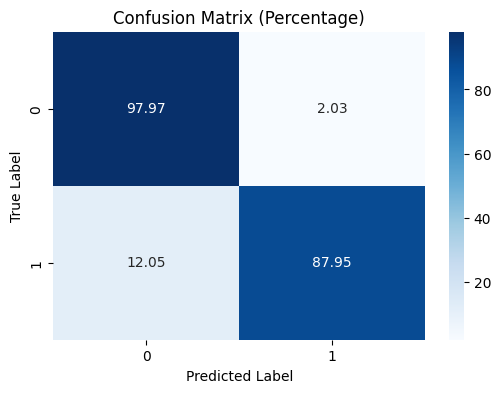

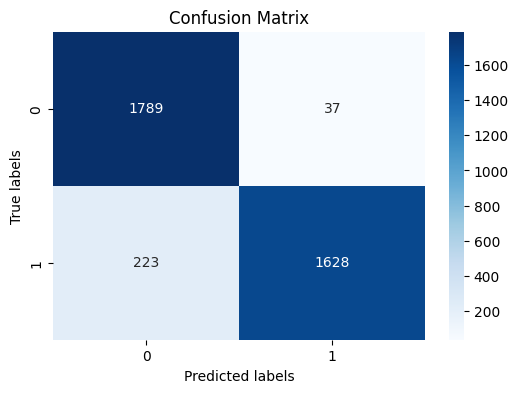

memory: None
steps: [('scaler', StandardScaler()), ('clf', RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=66))]
verbose: False
scaler: StandardScaler()
clf: RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=66)
scaler__copy: True
scaler__with_mean: True
scaler__with_std: True
clf__bootstrap: True
clf__ccp_alpha: 0.0
clf__class_weight: None
clf__criterion: gini
clf__max_depth: 10
clf__max_features: sqrt
clf__max_leaf_nodes: None
clf__max_samples: None
clf__min_impurity_decrease: 0.0
clf__min_samples_leaf: 2
clf__min_samples_split: 10
clf__min_weight_fraction_leaf: 0.0
clf__n_estimators: 50
clf__n_jobs: None
clf__oob_score: False
clf__random_state: 66
clf__verbose: 0
clf__warm_start: False


In [52]:
model_t5 = RandomForestClassifier(random_state=random_state, bootstrap=True, criterion='gini', max_depth=10,
                               max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease= 0.0 , 
                               min_samples_leaf= 2, min_samples_split= 10, min_weight_fraction_leaf= 0.0, 
                               n_estimators= 50)

pipeline_t5 = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model_t5)])

feats_elected_t5 = ['punctuation_mark', 'digit', 'ADP', 'words_density', 'NUM', 'VERB', 'blank', 'DET', 'vowel', 'PRON', 'NOUN', 'PRT', 'uppercase_middle', 'ADV', 'four_or_more_consonants', 'three_or_more_digits_or_letters_equal']


X_train_subset_t5 = X_train_t5[feats_elected_t5]
X_validation_subset_t5 = X_validation_t5[feats_elected_t5]

pipeline_t5.fit(X_train_subset_t5, y_train_t5)
predictions = pipeline_t5.predict(X_validation_subset_t5)


validation_accuracy = accuracy_score(y_validation_t5, predictions)
validation_recall = recall_score(y_validation_t5, predictions, average='macro')
print('accuracy: ', validation_accuracy)
print('recall: ', validation_recall)

conf_matrix_test = confusion_matrix(y_validation_t5, predictions)


row_totals = conf_matrix_test.sum(axis=1)
conf_matrix_percentage = conf_matrix_test / row_totals[:, np.newaxis] * 100 


# relative_confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentage)')
plt.show()     

# Absolute confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

false_negatives_idx = (predictions == 0) & (y_validation_t5 == 1)

false_negatives = X_validation_t5[false_negatives_idx]

hyperparameters = pipeline_t5.get_params()

for param, value in hyperparameters.items():
    print(f'{param}: {value}')

In [53]:
false_negatives

,text,error,POS,a,b,c,d,e,f,g,...,NOUN,PRON,ADJ,ADV,ADP,CONJ,DET,NUM,PRT,X
10936,UEFA Youth League semi-finals kick off at 3pm ...,1,"[(UEFA, NOUN), (Youth, NOUN), (League, NOUN), ...",0.080214,0.000000,0.021390,0.016043,0.122995,0.026738,0.016043,...,0.351351,0.027027,0.108108,0.000000,0.135135,0.000000,0.135135,0.054054,0.027027,0.00
10956,Zlatan Ibrahimovic opened the scoring from the...,1,"[(Zlatan, NOUN), (Ibrahimovic, NOUN), (opened,...",0.087324,0.008451,0.039437,0.036620,0.095775,0.028169,0.014085,...,0.348485,0.015152,0.090909,0.030303,0.121212,0.015152,0.166667,0.000000,0.060606,0.00
11246,Alastair Cook failed with the bat again on day...,1,"[(Alastair, NOUN), (Cook, NOUN), (failed, VERB...",0.077922,0.008658,0.012987,0.021645,0.073593,0.034632,0.017316,...,0.266667,0.022222,0.088889,0.111111,0.177778,0.000000,0.066667,0.066667,0.022222,0.00
10941,Dikembe Mutombo was an eight-times NBA All-Sta...,1,"[(Dikembe, NOUN), (Mutombo, NOUN), (was, VERB)...",0.079772,0.019943,0.008547,0.022792,0.094017,0.034188,0.025641,...,0.307692,0.061538,0.076923,0.015385,0.153846,0.030769,0.092308,0.046154,0.015385,0.00
13880,Dozens of items from the entertainer's ashes w...,1,"[(Dozens, NOUN), (of, ADP), (items, NOUN), (fr...",0.066667,0.000000,0.035897,0.051282,0.112821,0.015385,0.010256,...,0.368421,0.000000,0.000000,0.000000,0.105263,0.052632,0.157895,0.000000,0.105263,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11267,Barcelona beat PSG 3-1 in the Champions League...,1,"[(Barcelona, NOUN), (beat, NOUN), (PSG, NOUN),...",0.080460,0.015326,0.019157,0.022989,0.099617,0.019157,0.030651,...,0.347826,0.021739,0.108696,0.021739,0.152174,0.021739,0.108696,0.021739,0.021739,0.00
10884,"Gary, 44, and his best friend, Kirsty, arrange...",1,"[(Gary, NOUN), (,, .), (44, NUM), (,, .), (and...",0.040000,0.013333,0.000000,0.026667,0.100000,0.020000,0.020000,...,0.281250,0.093750,0.031250,0.031250,0.093750,0.031250,0.093750,0.031250,0.000000,0.00
16380,"The Killers, the Killers and William the Kille...",1,"[(The, DET), (Killers, NOUN), (,, .), (the, DE...",0.044776,0.009950,0.000000,0.019900,0.099502,0.019900,0.004975,...,0.309524,0.000000,0.023810,0.023810,0.119048,0.023810,0.142857,0.047619,0.047619,0.00
10908,Rob Williams and Led Zeppelin backtracked on p...,1,"[(Rob, NOUN), (Williams, NOUN), (and, CONJ), (...",0.059829,0.012821,0.012821,0.029915,0.094017,0.017094,0.008547,...,0.318182,0.000000,0.113636,0.000000,0.136364,0.045455,0.159091,0.000000,0.022727,0.00


#### Testing the model

accuracy:  0.9308093994778068
recall:  0.9308093994778068


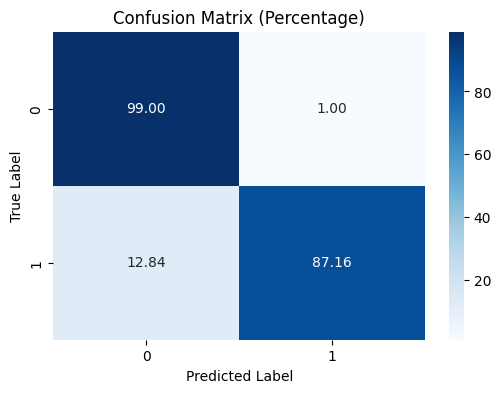

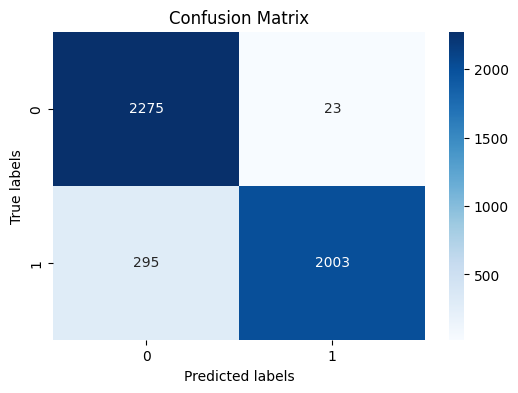

In [54]:
X_test_t5 = dfProcessed_t5_test[feats_elected_t5]
y_test_t5 = dfProcessed_t5_test['error']


predicted_probabilities_test = pipeline_t5.predict_proba(X_test_t5)[:, 1] 

threshold = 0.6009
# Convertir las probabilidades en predicciones binarias utilizando el umbral
predictions_test = (predicted_probabilities_test > threshold).astype(int)
conf_matrix_test = confusion_matrix(y_test_t5, predictions_test)
validation_accuracy = accuracy_score(y_test_t5, predictions_test)
validation_recall = recall_score(y_test_t5, predictions_test, average='macro')
print('accuracy: ', validation_accuracy)
print('recall: ', validation_recall)

row_totals = conf_matrix_test.sum(axis=1)
conf_matrix_percentage = conf_matrix_test / row_totals[:, np.newaxis] * 100  
# Crea el heatmap con porcentajes
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentage)')
plt.show()      
# Mostrar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
false_negatives_test_idx = (predictions_test == 0) & (y_test_t5 == 1)
# Obtener las entradas que dieron falsos negativos
false_negatives_test = dfProcessed_t5_test[false_negatives_test_idx]
#false_negatives_test.to_excel('./false_negatives_test.xlsx', index=False)

In [55]:
false_negatives_test

,text,error,POS,a,b,c,d,e,f,g,...,NOUN,PRON,ADJ,ADV,ADP,CONJ,DET,NUM,PRT,X
2321,"Liana Barrientos, a New York divorcee, alleged...",1,"[(Liana, NOUN), (Barrientos, NOUN), (,, .), (a...",0.077869,0.012295,0.024590,0.016393,0.090164,0.032787,0.016393,...,0.333333,0.000000,0.088889,0.044444,0.066667,0.022222,0.111111,0.066667,0.022222,0.0
2322,The remains of a man found Saturday in Cambrid...,1,"[(The, DET), (remains, NOUN), (of, ADP), (a, D...",0.106742,0.011236,0.028090,0.028090,0.084270,0.011236,0.028090,...,0.343750,0.000000,0.031250,0.000000,0.093750,0.000000,0.187500,0.031250,0.031250,0.0
2323,"The new season of ""True Detective is set for r...",1,"[(The, DET), (new, ADJ), (season, NOUN), (of, ...",0.072727,0.000000,0.024242,0.018182,0.133333,0.036364,0.000000,...,0.419355,0.000000,0.096774,0.000000,0.096774,0.032258,0.096774,0.032258,0.000000,0.0
2324,Police officers accompanied the hearse carryin...,1,"[(Police, NOUN), (officers, NOUN), (accompanie...",0.070707,0.015152,0.060606,0.020202,0.095960,0.025253,0.010101,...,0.394737,0.026316,0.052632,0.000000,0.078947,0.000000,0.157895,0.000000,0.052632,0.0
2325,"Elizabeth Sedway, a passenger on a plane to Ha...",1,"[(Elizabeth, NOUN), (Sedway, NOUN), (,, .), (a...",0.094340,0.007547,0.007547,0.022642,0.135849,0.007547,0.015094,...,0.306122,0.040816,0.061224,0.020408,0.102041,0.020408,0.142857,0.000000,0.040816,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4591,"Lynn, from Chippenham, has a painful and cripp...",1,"[(Lynn, NOUN), (,, .), (from, ADP), (Chippenha...",0.074074,0.003367,0.040404,0.030303,0.063973,0.016835,0.003367,...,0.271186,0.050847,0.033898,0.067797,0.084746,0.050847,0.118644,0.000000,0.016949,0.0
4592,Malaysia Airlines Flight MH17 was shot down ov...,1,"[(Malaysia, NOUN), (Airlines, NOUN), (Flight, ...",0.061321,0.018868,0.014151,0.033019,0.094340,0.018868,0.014151,...,0.342105,0.000000,0.105263,0.000000,0.157895,0.000000,0.026316,0.078947,0.026316,0.0
4593,"Clay Aiken, the loser in a November contest to...",1,"[(Clay, NOUN), (Aiken, NOUN), (,, .), (the, DE...",0.042945,0.021472,0.033742,0.018405,0.122699,0.003067,0.009202,...,0.383333,0.000000,0.066667,0.000000,0.133333,0.016667,0.133333,0.016667,0.033333,0.0
4594,Dana Vulin was set alight at her Perth home in...,1,"[(Dana, NOUN), (Vulin, NOUN), (was, VERB), (se...",0.070938,0.009153,0.027460,0.032037,0.100686,0.016018,0.006865,...,0.304878,0.085366,0.097561,0.048780,0.134146,0.024390,0.024390,0.024390,0.036585,0.0


#### Importance of features

In [56]:
importances = pipeline_t5.named_steps['clf'].feature_importances_

importance_df = pd.DataFrame({'Feature': X_train_subset_t5.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)
print(importance_df['Feature'].values)

                                  Feature  Importance
0                        punctuation_mark    0.184867
1                                   digit    0.124824
2                                     ADP    0.115476
4                                     NUM    0.096612
3                           words_density    0.090648
5                                    VERB    0.087434
6                                   blank    0.077034
9                                    PRON    0.052072
8                                   vowel    0.043093
7                                     DET    0.034348
12                       uppercase_middle    0.028988
10                                   NOUN    0.025959
13                                    ADV    0.014529
11                                    PRT    0.012235
15  three_or_more_digits_or_letters_equal    0.008664
14                four_or_more_consonants    0.003216
['punctuation_mark' 'digit' 'ADP' 'NUM' 'words_density' 'VERB' 'blank'
 'PRON' 'vo

In [57]:
list_test_time_txt = df_test_t5['text'].tolist()
list_test_time_error = df_test_t5['error'].tolist()

In [58]:

t0 = time.time()
len_elements = len(list_test_time_txt)
#len_elements = 1
for i in range(len_elements):
    process_single_element(list_test_time_txt[i],list_test_time_error[i], threshold, pipeline_t5)
tf = time.time()

dTimes = (tf - t0) * 1000
print("dTimes (ms): ", dTimes)
mean_pred_time = dTimes/len_elements
print("mean_pred_time (ms): ", mean_pred_time)

dTimes (ms):  51009.830474853516
mean_pred_time (ms):  11.098744663806247


In [78]:
dump(pipeline_t5, './models/pipeline_t5_model.joblib')

['./models/pipeline_t5_model.joblib']

## Opus

In [60]:
df_no_error_opus_raw = read_file_create_dataframe('./datasets/fault_inject_result_opus_8K/iwslt2017_output_predict_fault_free.txt', 0)
df_error_opus_raw = read_file_create_dataframe('./datasets/fault_inject_result_opus_8K/iwslt2017_output_predict_single_fi_bit_100times.txt', 1)

In [61]:
df_error_opus_raw

,text,error
0,a a a a a a a a a a a a a a a a a a a a a a a ...,1
1,a a a a a a a a a a a a a a a a a a a a a a a ...,1
2,.................................................,1
3,",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...",1
4,",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...",1
...,...,...
854895,"A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...",1
854896,"A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...",1
854897,"A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...",1
854898,"A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...",1


### Balancing the dataset

In [62]:
n_errors_opus = len(df_error_opus_raw)/len(df_no_error_opus_raw)
print("n_errors_opus: ", n_errors_opus)
samples_opus = len(df_no_error_opus_raw)
print("samples_opus: ", samples_opus)
samples_per_error_opus = math.ceil(samples_opus/n_errors_opus)
print("samples_per_error_opus: ", samples_per_error_opus)

df_error_raw_subsample_opus_raw = subsample_error(df_error_opus_raw, samples_opus, samples_per_error_opus)
print(df_error_raw_subsample_opus_raw)

n_errors_opus:  100.0
samples_opus:  8549
samples_per_error_opus:  86
                                                     text  error
0       a a a a a a a a a a a a a a a a a a a a a a a ...      1
1       a a a a a a a a a a a a a a a a a a a a a a a ...      1
2       .................................................      1
3       ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...      1
4       ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...      1
...                                                   ...    ...
854895  A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...      1
854896  A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...      1
854897  A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...      1
854898  A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...      1
854899  A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...      1

[8549 rows x 2 columns]


### POS tagging

In [63]:
df_no_error_opus_raw['POS'] = df_no_error_opus_raw['text'].apply(pos_tagging)
df_error_raw_subsample_opus_raw['POS'] = df_error_raw_subsample_opus_raw['text'].apply(pos_tagging)

### Splitting test dataset

In [64]:
n = 5
[df_no_error_opus, df_no_error_opus_test] = extract_one_per_n(df_no_error_opus_raw, n)
[df_error_opus, df_error_opus_test] = extract_one_per_n(df_error_raw_subsample_opus_raw, n)


df_no_error_opus_sample = df_no_error_opus.iloc[0:]
df_error_opus_sample = df_error_opus.iloc[0:]

df_opus = pd.concat([df_no_error_opus_sample, df_error_opus_sample], ignore_index=True)
df_opus = df_opus[df_opus['text'].str.len() != 0]

df_opus

,text,error,POS
0,It was a very simple idea to ask a team of fou...,0,"[(It, PRON), (was, VERB), (a, DET), (very, ADV..."
1,The marshmallows have to be at the top.\n,0,"[(The, DET), (marshmallows, NOUN), (have, VERB..."
2,"It may seem simple, but it's not easy because ...",0,"[(It, PRON), (may, VERB), (seem, VERB), (simpl..."
3,I think it's an interesting idea. I put it in ...,0,"[(I, PRON), (think, VERB), (it, PRON), ('s, VE..."
4,"Since then, I've had more than 70 design discu...",0,"[(Since, ADP), (then, ADV), (,, .), (I, PRON),..."
...,...,...,...
13673,"A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...",1,"[(A.S.A.S.A.S.A, NOUN), (., .), (,, .), (A.S.,..."
13674,"A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...",1,"[(A.S.A.S.A.S.A, NOUN), (., .), (,, .), (A.S.,..."
13675,"A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...",1,"[(A.S.A.S.A.S.A, NOUN), (., .), (,, .), (A.S.,..."
13676,"A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...",1,"[(A.S.A.S.A.S.A, NOUN), (., .), (,, .), (A.S.,..."


### Preprocessing datasets

In [65]:
df_no_error_sample_opus_test = df_no_error_opus_test.iloc[0:]
df_error_sample_opus_test = df_error_opus_test.iloc[0:]
df_opus_test = pd.concat([df_no_error_sample_opus_test, df_error_sample_opus_test], ignore_index=True)
df_opus_test = df_opus_test[df_opus_test['text'].str.len() != 0]
df_opus_test

,text,error,POS
0,"A few years ago, at the TED Conference, Peter ...",0,"[(A, DET), (few, ADJ), (years, NOUN), (ago, AD..."
1,The results were very successful.\n,0,"[(The, DET), (results, NOUN), (were, VERB), (v..."
2,It took them a lot of time to get the pasta up...,0,"[(It, PRON), (took, VERB), (them, PRON), (a, D..."
3,"And, of course, there were teams that created ...",0,"[(And, CONJ), (,, .), (of, ADP), (course, NOUN..."
4,They don't spend any time fighting for power.\n,0,"[(They, PRON), (do, VERB), (n't, ADV), (spend,..."
...,...,...,...
3415,"A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...",1,"[(A.S.A.S.A.S.A, NOUN), (., .), (,, .), (A.S.,..."
3416,"A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...",1,"[(A.S.A.S.A.S.A, NOUN), (., .), (,, .), (A.S.,..."
3417,"A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...",1,"[(A.S.A.S.A.S.A, NOUN), (., .), (,, .), (A.S.,..."
3418,"A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...",1,"[(A.S.A.S.A.S.A, NOUN), (., .), (,, .), (A.S.,..."


In [66]:
dfProcessed_opus = preprocess(df_opus)
dfProcessed_opus

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0


,text,error,POS,a,b,c,d,e,f,g,...,NOUN,PRON,ADJ,ADV,ADP,CONJ,DET,NUM,PRT,X
0,It was a very simple idea to ask a team of fou...,0,"[(It, PRON), (was, VERB), (a, DET), (very, ADV...",0.118519,0.014815,0.000000,0.037037,0.066667,0.014815,0.007407,...,0.258065,0.032258,0.064516,0.032258,0.064516,0.000000,0.193548,0.064516,0.064516,0.0
1,The marshmallows have to be at the top.\n,0,"[(The, DET), (marshmallows, NOUN), (have, VERB...",0.100000,0.025000,0.000000,0.000000,0.100000,0.000000,0.000000,...,0.222222,0.000000,0.000000,0.000000,0.111111,0.000000,0.222222,0.000000,0.111111,0.0
2,"It may seem simple, but it's not easy because ...",0,"[(It, PRON), (may, VERB), (seem, VERB), (simpl...",0.032967,0.021978,0.021978,0.000000,0.131868,0.000000,0.010989,...,0.052632,0.157895,0.105263,0.157895,0.052632,0.052632,0.000000,0.000000,0.052632,0.0
3,I think it's an interesting idea. I put it in ...,0,"[(I, PRON), (think, VERB), (it, PRON), ('s, VE...",0.045455,0.000000,0.000000,0.030303,0.060606,0.000000,0.030303,...,0.187500,0.250000,0.062500,0.000000,0.062500,0.000000,0.125000,0.000000,0.000000,0.0
4,"Since then, I've had more than 70 design discu...",0,"[(Since, ADP), (then, ADV), (,, .), (I, PRON),...",0.051852,0.000000,0.025926,0.044444,0.096296,0.003704,0.025926,...,0.211538,0.096154,0.076923,0.096154,0.134615,0.057692,0.038462,0.019231,0.019231,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13673,"A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...",1,"[(A.S.A.S.A.S.A, NOUN), (., .), (,, .), (A.S.,...",0.302613,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.490950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
13674,"A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...",1,"[(A.S.A.S.A.S.A, NOUN), (., .), (,, .), (A.S.,...",0.302613,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.490950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
13675,"A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...",1,"[(A.S.A.S.A.S.A, NOUN), (., .), (,, .), (A.S.,...",0.302613,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.490950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
13676,"A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...",1,"[(A.S.A.S.A.S.A, NOUN), (., .), (,, .), (A.S.,...",0.302613,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.490950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [67]:
dfProcessed_opus_test = preprocess(df_opus_test)
dfProcessed_opus_test

0.0
1.0
2.0
3.0


,text,error,POS,a,b,c,d,e,f,g,...,NOUN,PRON,ADJ,ADV,ADP,CONJ,DET,NUM,PRT,X
0,"A few years ago, at the TED Conference, Peter ...",0,"[(A, DET), (few, ADJ), (years, NOUN), (ago, AD...",0.083333,0.000000,0.058333,0.041667,0.141667,0.016667,0.041667,...,0.454545,0.000000,0.045455,0.045455,0.045455,0.000000,0.181818,0.0,0.000000,0.0
1,The results were very successful.\n,0,"[(The, DET), (results, NOUN), (were, VERB), (v...",0.000000,0.000000,0.058824,0.000000,0.176471,0.029412,0.000000,...,0.166667,0.000000,0.166667,0.166667,0.000000,0.000000,0.166667,0.0,0.000000,0.0
2,It took them a lot of time to get the pasta up...,0,"[(It, PRON), (took, VERB), (them, PRON), (a, D...",0.070175,0.000000,0.000000,0.035088,0.070175,0.017544,0.017544,...,0.200000,0.133333,0.000000,0.133333,0.066667,0.066667,0.133333,0.0,0.066667,0.0
3,"And, of course, there were teams that created ...",0,"[(And, CONJ), (,, .), (of, ADP), (course, NOUN...",0.068966,0.008621,0.025862,0.034483,0.137931,0.017241,0.008621,...,0.192308,0.000000,0.115385,0.038462,0.076923,0.038462,0.192308,0.0,0.000000,0.0
4,They don't spend any time fighting for power.\n,0,"[(They, PRON), (do, VERB), (n't, ADV), (spend,...",0.021739,0.000000,0.000000,0.043478,0.086957,0.043478,0.043478,...,0.200000,0.100000,0.000000,0.100000,0.100000,0.000000,0.100000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,"A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...",1,"[(A.S.A.S.A.S.A, NOUN), (., .), (,, .), (A.S.,...",0.302613,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.490950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
3416,"A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...",1,"[(A.S.A.S.A.S.A, NOUN), (., .), (,, .), (A.S.,...",0.302613,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.490950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
3417,"A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...",1,"[(A.S.A.S.A.S.A, NOUN), (., .), (,, .), (A.S.,...",0.302613,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.490950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
3418,"A.S.A.S.A.S.A. , A.S., A.S., A.S., A.S., A.S.,...",1,"[(A.S.A.S.A.S.A, NOUN), (., .), (,, .), (A.S.,...",0.302613,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.490950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0


In [68]:
save_excel_chunks(dfProcessed_opus, './backup_df_saved/dfProcessed_opus', chunk_size)
save_excel_chunks(dfProcessed_opus_test, './backup_df_saved/dfProcessed_opus_test', chunk_size)

### Training
#### Splitting train validation dataset

In [69]:
X_opus = dfProcessed_opus
y_opus = dfProcessed_opus['error']

In [70]:
X_opus_train, X_opus_validation, y_opus_train, y_opus_validation = train_test_split(X_opus, y_opus, test_size=0.2, random_state=random_state)


#### Training the final model and validation

accuracy:  0.9546783625730995
recall:  0.954706659050359


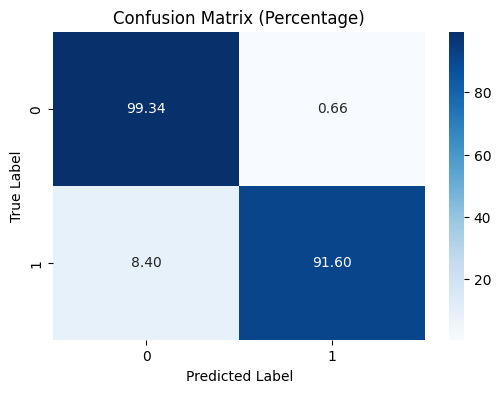

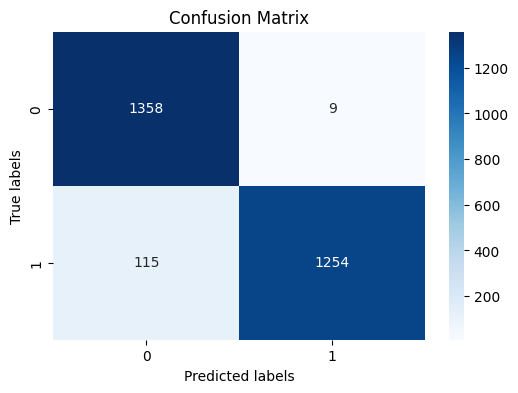

memory: None
steps: [('scaler', StandardScaler()), ('clf', RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=66))]
verbose: False
scaler: StandardScaler()
clf: RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=66)
scaler__copy: True
scaler__with_mean: True
scaler__with_std: True
clf__bootstrap: True
clf__ccp_alpha: 0.0
clf__class_weight: None
clf__criterion: gini
clf__max_depth: 10
clf__max_features: sqrt
clf__max_leaf_nodes: None
clf__max_samples: None
clf__min_impurity_decrease: 0.0
clf__min_samples_leaf: 2
clf__min_samples_split: 10
clf__min_weight_fraction_leaf: 0.0
clf__n_estimators: 50
clf__n_jobs: None
clf__oob_score: False
clf__random_state: 66
clf__verbose: 0
clf__warm_start: False


In [71]:
model_opus = RandomForestClassifier(random_state=random_state, bootstrap=True, criterion='gini', max_depth=10,
                               max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease= 0.0 , 
                               min_samples_leaf= 2, min_samples_split= 10, min_weight_fraction_leaf= 0.0, 
                               n_estimators= 50)

pipeline_opus = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model_opus)])


feats_elected_opus = feats_elected_t5
#feats_elected_opus = ['punctuation_mark', 'digit', 'ADP', 'words_density', 'NUM', 'VERB', 'blank', 'DET', 'vowel', 'PRON', 'NOUN', 'PRT', 'uppercase_middle', 'ADV', 'four_or_more_consonants', 'three_or_more_digits_or_letters_equal']



X_opus_train_subset = X_opus_train[feats_elected_opus]
X_opus_validation_subset = X_opus_validation[feats_elected_opus]

pipeline_opus.fit(X_opus_train_subset, y_opus_train)

threshold = 0.5

predictions = pipeline_opus.predict(X_opus_validation_subset)


validation_accuracy = accuracy_score(y_opus_validation, predictions)
validation_recall = recall_score(y_opus_validation, predictions, average='macro')
print('accuracy: ', validation_accuracy)
print('recall: ', validation_recall)

conf_matrix_test = confusion_matrix(y_opus_validation, predictions)


row_totals = conf_matrix_test.sum(axis=1)
conf_matrix_percentage = conf_matrix_test / row_totals[:, np.newaxis] * 100 


plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentage)')
plt.show()     

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

false_negatives_idx = (predictions == 0) & (y_opus_validation == 1)

false_negatives = X_opus_validation[false_negatives_idx]

hyperparameters = pipeline_opus.get_params()

for param, value in hyperparameters.items():
    print(f'{param}: {value}')

### Testing the model

accuracy:  0.8763157894736842
recall:  0.8763157894736842


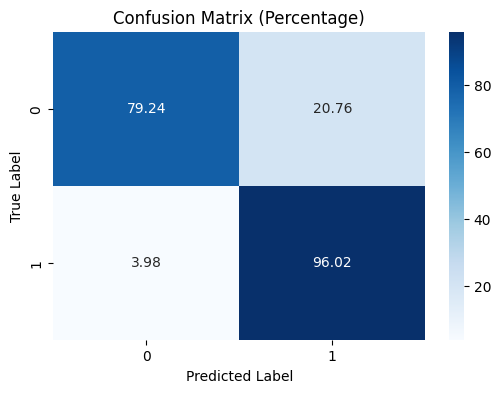

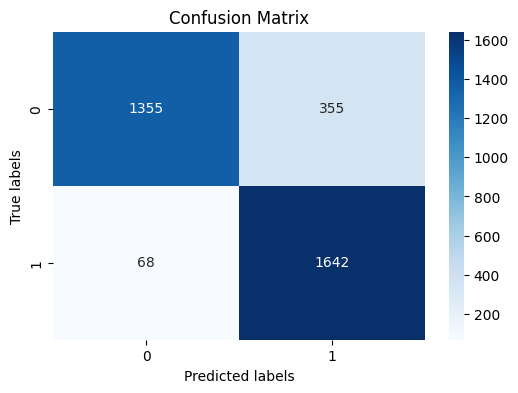

In [72]:
X_opus_test = dfProcessed_opus_test[feats_elected_opus]
y_opus_test = dfProcessed_opus_test['error']

pipeline_validation_opus = pipeline_opus 

predicted_probabilities_test_opus = pipeline_validation_opus.predict_proba(X_opus_test)[:, 1] 

threshold_opus = 0.1
predictions_test_opus = (predicted_probabilities_test_opus > threshold_opus).astype(int)
#predictions_test_opus = pipeline_validation_opus.predict(X_opus_test)
conf_matrix_test = confusion_matrix(y_opus_test, predictions_test_opus)
validation_accuracy = accuracy_score(y_opus_test, predictions_test_opus)
validation_recall = recall_score(y_opus_test, predictions_test_opus, average='macro')
print('accuracy: ', validation_accuracy)
print('recall: ', validation_recall)

row_totals = conf_matrix_test.sum(axis=1)
conf_matrix_percentage = conf_matrix_test / row_totals[:, np.newaxis] * 100  
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentage)')
plt.show()      
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
false_negatives_test_idx = (predictions_test_opus == 0) & (y_opus_test == 1)
false_positives_test_idx = (predictions_test_opus == 1) & (y_opus_test == 0)
true_positive_test_idx =  (predictions_test_opus == 1) & (y_opus_test == 1)
true_negatives_test_idx = (predictions_test_opus == 0) & (y_opus_test == 0)
false_negatives_test = dfProcessed_opus_test[false_negatives_test_idx]
#false_negatives_test.to_excel('./false_negatives_test_opus.xlsx', index=False)
false_positives_test = dfProcessed_opus_test[false_positives_test_idx]
#false_positives_test.to_excel('./false_positives_test_opus.xlsx', index=False)

true_positives_test = dfProcessed_opus_test[true_positive_test_idx]
true_negatives_test = dfProcessed_opus_test[true_negatives_test_idx]


### Time to execute the model

In [73]:
list_test_time_txt_opus = df_opus_test['text'].tolist()
list_test_time_error_opus = df_opus_test['error'].tolist()

In [74]:
t0 = time.time()
len_elements = len(list_test_time_txt_opus)
for i in range(len_elements):
    process_single_element(list_test_time_txt_opus[i],list_test_time_error_opus[i], threshold_opus, pipeline_validation_opus)
tf = time.time()

dTimes = (tf - t0) * 1000
print("dTimes (ms): ", dTimes)
mean_pred_time = dTimes/len_elements
print("mean_pred_time (ms): ", mean_pred_time)

dTimes (ms):  35269.10614967346
mean_pred_time (ms):  10.312604137331421


In [77]:
dump(pipeline_validation_opus, './models/pipeline_opus_model.joblib')

['./models/pipeline_opus_model.joblib']

## ROC curves

In [79]:
t5_pipeline = load('./models/pipeline_t5_model.joblib')
opus_pipeline = load('./models/pipeline_opus_model.joblib')

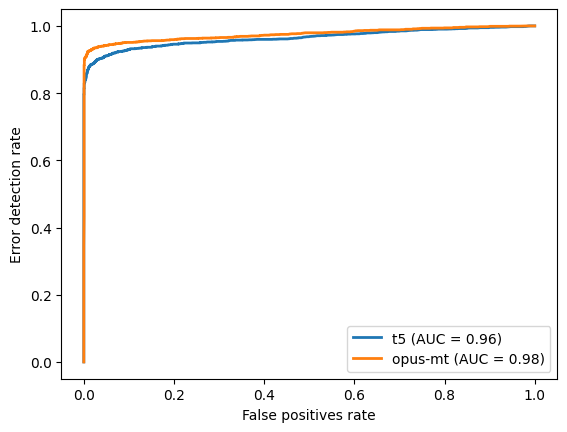

In [80]:
def get_threshold_fp_tp(pipeline, dfProcessed_test, feats_elected):
    feats_elected
    X_test_t5 = dfProcessed_test[feats_elected]
    y_test_t5 = dfProcessed_test['error']

    FP_list = []
    TP_list = []
    threshold_list = []
    predicted_probabilities_test = pipeline.predict_proba(X_test_t5)[:, 1] 
    
    for threshold in np.arange(0, 1.01, 0.0001):
        predictions_test = (predicted_probabilities_test > threshold).astype(int)
        conf_matrix_test = confusion_matrix(y_test_t5, predictions_test)
        row_totals = conf_matrix_test.sum(axis=1)
        conf_matrix_percentage = conf_matrix_test / row_totals[:, np.newaxis]  
        FP = conf_matrix_percentage[0, 1]
        TP = conf_matrix_percentage[1, 1] 
        FP_list.append(FP)
        TP_list.append(TP)
        threshold_list.append(threshold)
    auc_model = auc(FP_list, TP_list) 
    return [FP_list, TP_list, threshold_list, auc_model]


[FP_list_t5, TP_list_t5, threshold_list_t5, auc_t5] = get_threshold_fp_tp(t5_pipeline, dfProcessed_t5_test, feats_elected_t5)
[FP_list_opus, TP_list_opus, threshold_list_opus, auc_opus] = get_threshold_fp_tp(opus_pipeline, dfProcessed_opus_test, feats_elected_opus)

plt.plot(FP_list_t5, TP_list_t5, marker=None, linestyle='-', linewidth=2, label=f't5 (AUC = {auc_t5:.2f})')
plt.plot(FP_list_opus, TP_list_opus, marker=None, linestyle='-', linewidth=2, label=f'opus-mt (AUC = {auc_opus:.2f})')
plt.xlabel('False positives rate')
plt.ylabel('Error detection rate')
plt.legend()
plt.savefig('./figs/roc.png',  dpi=900, bbox_inches='tight')
plt.show()


